In [1]:
%load_ext autoreload
%autoreload 2

train_path = "../Datasets/JSRT/Train"
test_path = "../Datasets/JSRT/Test"
val_path = "../Datasets/JSRT/Val" 

In [2]:
import sys 
sys.path.append('..')

In [3]:
from models.hybrid import Hybrid as Hybrid
from models.hybridSkip import Hybrid as Skip
from models.hybridDoubleSkip import Hybrid as DoubleSkip

import os 

import torch
from torchvision import transforms
import numpy as np

from utils.dataLoader import LandmarksDataset, ToTensor, Rescale
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
from utils.utils import scipy_to_torch_sparse, genMatrixesLH

In [4]:
img_path = os.path.join(val_path, 'Images')
label_path = os.path.join(val_path, 'landmarks')
test_dataset = LandmarksDataset(img_path=img_path,
                                 label_path=label_path,
                                 transform = transforms.Compose([
                                             Rescale(1024),
                                             ToTensor()])
                                 )

device = 'cuda:0'

In [5]:
A, AD, D, U = genMatrixesLH()

A = sp.csc_matrix(A).tocoo()
AD = sp.csc_matrix(AD).tocoo()
D = sp.csc_matrix(D).tocoo()
U = sp.csc_matrix(U).tocoo()

D_ = [D.copy()]
U_ = [U.copy()]
A_ = [A.copy(), A.copy(), A.copy(), AD.copy(), AD.copy(), AD.copy()]

config = {}
config['n_nodes'] = [120, 120, 120, 60, 60, 60]

A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to(device) for x in X] for X in (A_, D_, U_))

config['latents'] = 64
config['inputsize'] = 1024

f = 32
config['filters'] = [2, f, f, f, f//2, f//2, f//2]
config['skip_features'] = f

config['window'] = (3,3)

config['l1'] = 5
config['l2'] = 4

In [6]:
config['K'] = 3

hybrid3 = Hybrid(config, D_t, U_t, A_t).to(device)
hybrid3.load_state_dict(torch.load("../weights/K_ablation/hybrid_k_3/bestMSE.pt"))
hybrid3.eval()

config['K'] = 5

hybrid5 = Hybrid(config, D_t, U_t, A_t).to(device)
hybrid5.load_state_dict(torch.load("../weights/K_ablation/hybrid_k_5/bestMSE.pt"))
hybrid5.eval()

config['K'] = 6

hybrid6 = Hybrid(config, D_t, U_t, A_t).to(device)
hybrid6.load_state_dict(torch.load("../weights/K_ablation/hybrid_k_6/bestMSE.pt"))
hybrid6.eval()

config['K'] = 7

hybrid7 = Hybrid(config, D_t, U_t, A_t).to(device)
hybrid7.load_state_dict(torch.load("../weights/K_ablation/hybrid_k_7/bestMSE.pt"))
hybrid7.eval()

config['K'] = 9

hybrid9 = Hybrid(config, D_t, U_t, A_t).to(device)
hybrid9.load_state_dict(torch.load("../weights/K_ablation/hybrid_k_9/bestMSE.pt"))
hybrid9.eval()
print('Models loaded')

Models loaded


In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

model_list = [hybrid3,hybrid5,hybrid6,hybrid7,hybrid9]
model_names = ['K:3','K:5','K:6','K:7','K:9']

results1 = pd.DataFrame()

for i in range(0, len(test_dataset.images)):   
    print('\r',i+1,'of', len(test_dataset.images),end='')
    with torch.no_grad():
        sample = test_dataset[i]

        data, target = sample['image'], sample['landmarks']
        data = torch.unsqueeze(data, 0).to(device)
        target =  target[:120,:].reshape(-1).numpy()
        
        for j in range(0, len(model_list)):
            output = model_list[j](data)
            if len(output) > 1:
                output = output[0]
            output = output.cpu().numpy().reshape(-1)
            
            error = mean_squared_error(target * 1024, output * 1024)
            
            aux = pd.DataFrame([[i, error, model_names[j]]], columns=['i','MSE', 'Model'])
            results1 = results1.append(aux, ignore_index = True)

 21 of 21

MSE
K:3 	385.563 +- 374.874
K:5 	293.351 +- 239.174
K:6 	283.996 +- 210.335
K:7 	273.051 +- 214.095
K:9 	370.033 +- 302.382



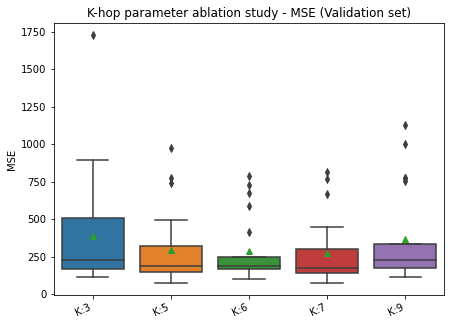

In [8]:
plt.figure(figsize = (7,5))
plt.tight_layout()
sns.boxplot(x = 'Model', y = 'MSE', data = results1, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('MSE')
plt.title('K-hop parameter ablation study - MSE (Validation set)')
plt.xlabel(None)
plt.savefig('figs/k_parameter.png', dpi = 200)
print('MSE')
for model in model_names:
    print(model, '\t' '%.3f'%np.mean(results1['MSE'][results1['Model'] == model]), '+- %.3f' % np.std(results1['MSE'][results1['Model'] == model]))

print('')

In [9]:
from medpy.metric import dc, hd, assd, jc, asd
from utils.fun import reverseVector, drawBinary

def evalImageMetrics(blank, output, target_lungs, target_heart):
    p1, p2, h, c1, c2 = reverseVector(output)
    
    ptest = drawBinary(blank.copy(), p1)
    ptest = drawBinary(ptest, p2)
    
    hdp = hd(ptest, target_lungs, voxelspacing = 0.35)
    dcp = dc(ptest, target_lungs)

    p1, p2, h, c1, c2 = reverseVector(output)
    
    ptest = drawBinary(blank.copy(), h)
    
    hdc = hd(ptest, target_heart, voxelspacing = 0.35)
    dcc = dc(ptest, target_heart)
    
    return [dcp, dcc, hdp, hdc]

def evalImageMetricsUNet(output, target_lungs, target_heart):
    dcp = dc(output == 1, target_lungs)
    dcc = dc(output == 2, target_heart)
    
    hdp = hd(output == 1, target_lungs, voxelspacing = 0.35)
    hdc = hd(output == 2, target_heart, voxelspacing = 0.35)
        
    return [dcp, dcc, hdp, hdc]

In [10]:
blank = np.zeros([1024, 1024])

results = pd.DataFrame()

for i in range(0, len(test_dataset.images)):
    print('\r',i+1,'of', len(test_dataset.images),end='')
    with torch.no_grad():
        sample = test_dataset[i]

        data, target = sample['image'], sample['landmarks']
        data = torch.unsqueeze(data, 0).to(device)
        target =  target.reshape(-1).numpy()
        
        p1, p2, h, c1, c2 = reverseVector(target * 1024)
       
        t_lungs = drawBinary(blank.copy(), p1)
        t_lungs = drawBinary(t_lungs, p2)
        t_heart = drawBinary(blank.copy(), h)
        
        for j in range(0, len(model_list)):
            output = model_list[j](data)
            if len(output) > 1:
                output = output[0]
                
            output = output.cpu().numpy().reshape(-1) 
            
            metrics = evalImageMetrics(blank, output * 1024, t_lungs, t_heart)
             
            aux = pd.DataFrame([[i, model_names[j]] + metrics], columns=['i','Model','Dice Lungs','Dice Heart','HD Lungs','HD Heart'])
            results = results.append(aux, ignore_index = True)

 21 of 21

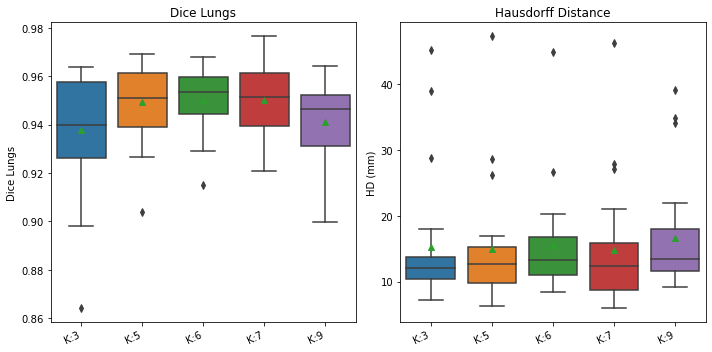

Dice
K:3 0.938 +- 0.025
K:5 0.949 +- 0.016
K:6 0.950 +- 0.013
K:7 0.950 +- 0.014
K:9 0.941 +- 0.017

Hausdorff
K:3 15.309 +- 9.744
K:5 14.925 +- 9.000
K:6 15.506 +- 7.827
K:7 14.860 +- 9.123
K:9 16.702 +- 8.485



In [11]:
plt.figure(figsize = (10,5))
plt.tight_layout()
ax = plt.subplot(1,2,1)
sns.boxplot(x = 'Model', y = 'Dice Lungs', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice Lungs')
plt.title('Dice Lungs')
plt.xlabel(None)

ax = plt.subplot(1,2,2)
sns.boxplot(x = 'Model', y = 'HD Lungs', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (mm)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

plt.tight_layout()
plt.show()

print('Dice')
for model in model_names:
    print(model, '%.3f'%np.mean(results['Dice Lungs'][results['Model'] == model]), '+- %.3f' % np.std(results['Dice Lungs'][results['Model'] == model]))

print('')

print('Hausdorff')
for model in model_names:
    print(model, '%.3f'%np.mean(results['HD Lungs'][results['Model'] == model]), '+- %.3f' % np.std(results['HD Lungs'][results['Model'] == model]))

print('')

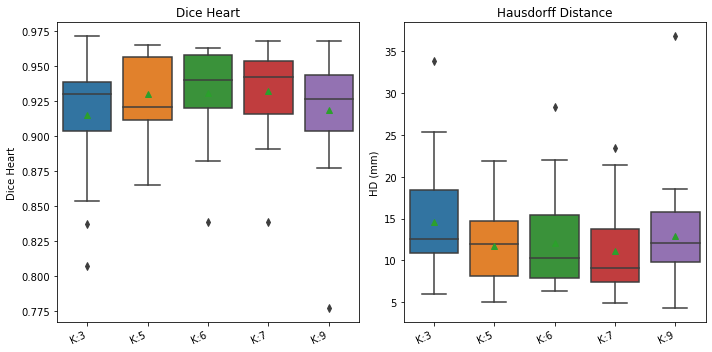

Dice
K:3 0.915 +- 0.043
K:5 0.930 +- 0.027
K:6 0.931 +- 0.032
K:7 0.932 +- 0.031
K:9 0.919 +- 0.042

Hausdorff
K:3 14.544 +- 6.685
K:5 11.740 +- 4.459
K:6 12.087 +- 5.341
K:7 11.112 +- 5.217
K:9 12.957 +- 6.458



In [12]:
plt.figure(figsize = (10,5))
plt.tight_layout()
ax = plt.subplot(1,2,1)
sns.boxplot(x = 'Model', y = 'Dice Heart', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice Heart')
plt.title('Dice Heart')
plt.xlabel(None)

ax = plt.subplot(1,2,2)
sns.boxplot(x = 'Model', y = 'HD Heart', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (mm)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

plt.tight_layout()
plt.show()

print('Dice')
for model in model_names:
    print(model, '%.3f'%np.mean(results['Dice Heart'][results['Model'] == model]), '+- %.3f' % np.std(results['Dice Heart'][results['Model'] == model]))

print('')

print('Hausdorff')
for model in model_names:
    print(model, '%.3f'%np.mean(results['HD Heart'][results['Model'] == model]), '+- %.3f' % np.std(results['HD Heart'][results['Model'] == model]))

print('')